## Cyton vs. OpenSignals Recordings

This file is intended for comparing the signal qualities of the Cyton and BioSignalPlux devices.

### 1. Read OpenSignals File


In [80]:
import json

def read_opensignals(filename):
    # Open the file and read line by line
    with open(filename, 'r') as f:
        lines = f.readlines()
        if not lines[0].startswith("# OpenSignals Text File "):
            raise ValueError("Invalid file format. The file should start with '# OpenSignals Text File ...'")
        
        metadata = None
        metadata_num_rows = 1
        for line in lines[1:]:
            if line.startswith("#"):
                metadata_num_rows += 1
                if metadata is not None:
                    continue
                metadata_string = line[1:].replace("# ", "")
                metadata = json.loads(metadata_string)
            else:
                break

        if metadata is None:
            raise ValueError("Invalid file format. Metadata not found.")
        
        # Read the data row by row into the dataframe 
        devices = list(metadata.keys())
        if len(devices) != 1:
            raise ValueError(f"This tool currently only supports parsing data collected from exactly 1 device, but found {len(devices)} device(s) in the metadata.")
        metadata = metadata[devices[0]]


        columns = metadata["column"]
        print(f"Columns: {columns}. Please adjust the graphed index as needed.")
        
        data = []
        for line in lines[metadata_num_rows:]:
            row = line.strip().split("\t")
            data.append((float(row[2])))                         # Adjust the appended index based on which column you want.

        return metadata, data

### 2. Define Timestamping Functions

In [81]:
def parse_time(time_str):
    [hours, minutes, seconds] = time_str.split(":")
    total_seconds = float(hours) * 3600 + float(minutes) * 60 + float(seconds)
    return total_seconds

def zip_time_and_signals(start_time, sample_rate, data, downsample_to=None):
    start_time_seconds = parse_time(start_time)
    increment = 1 / sample_rate
    
    timestamps = []
    signal_data = []
    
    # Generate timestamps and collect data
    for i, value in enumerate(data):
        if downsample_to is not None and i % downsample_to != 0:
            continue
        current_time = start_time_seconds + i * increment
        timestamps.append(current_time)
        signal_data.append(value)
    
    return timestamps, signal_data

### 3. Get OpenSignals Data and Timestamps

In [82]:
meta_data, opensignals_raw = read_opensignals("../results/2024-07-30-15-58-42/OpenSignals/test-opensignals_0007808c08eb_2024-07-30_15-58-43.txt")
opensignals_timestamps, _ = zip_time_and_signals(meta_data["time"], 500, opensignals_raw)

Columns: ['nSeq', 'DI', 'CH1']. Please adjust the graphed index as needed.


### 4. Read and Get Cyton Data and Timestamps

In [83]:
def read_json_from_file(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return data

cyton_dict = read_json_from_file("../results/2024-07-30-15-58-42/Cyton/0-data.json")
cyton_time, cyton_raw = cyton_dict["window_begin_time"], cyton_dict["Fp1"]
cyton_timestamps, _ = zip_time_and_signals(cyton_time, 250, cyton_raw)

### 5. Graph Two Datasets

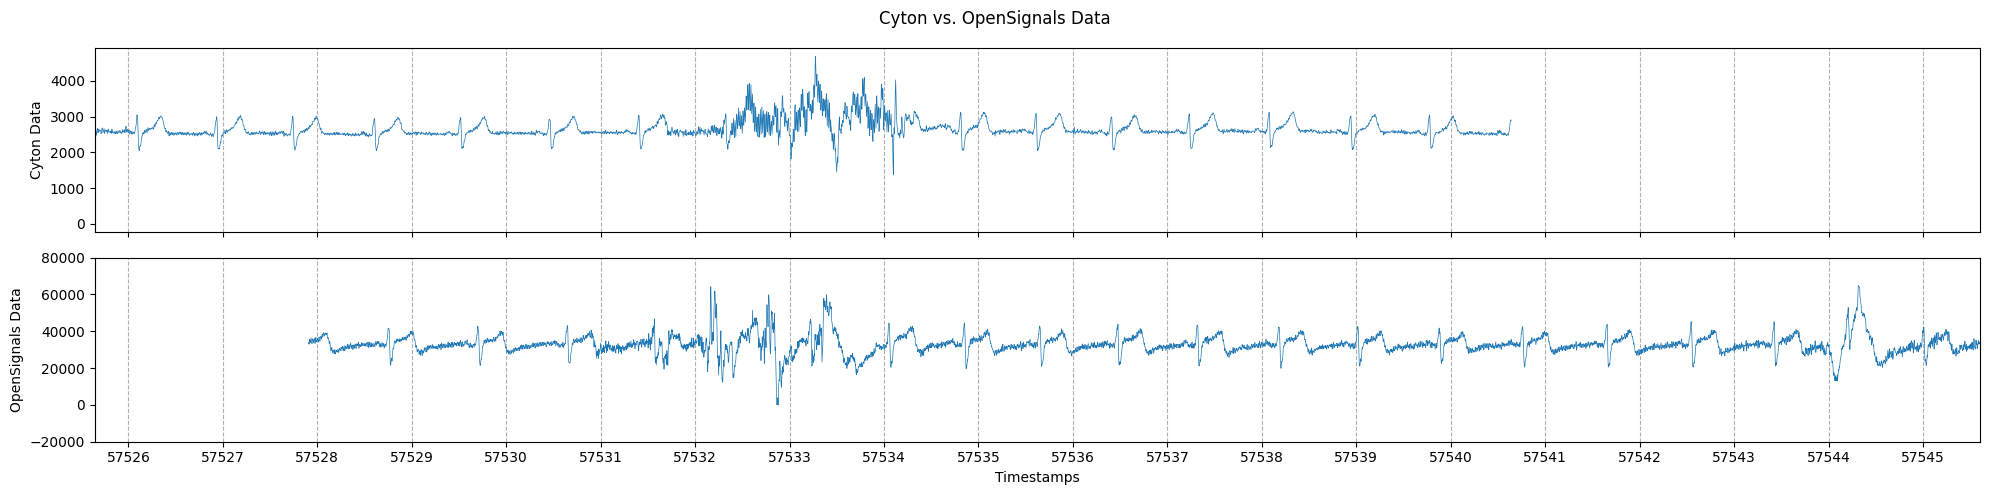

In [96]:
import matplotlib.pyplot as plt

# Create the figure and axes
fig, ax = plt.subplots(2, 1, figsize=(20, 5), sharex=True)  # Add sharex=True to share the x-axis

# Plot the Cyton data with thinner line
ax[0].plot(cyton_timestamps, cyton_raw, linewidth=0.5)
ax[0].set_ylabel('Cyton Data')
ax[0].set_xticks([])  # Remove x-axis labels from the first graph

# Plot the OpenSignals data with thinner line
ax[1].plot(opensignals_timestamps, opensignals_raw, linewidth=0.5)
ax[1].set_ylabel('OpenSignals Data')
ax[1].set_ylim(-20000, 80000)  # Set the y-axis range
ax[1].set_xticks(range(int(min_timestamp), int(max_timestamp)+1))  # Set x-axis labels for every increment of 1 in x

# Set the x-axis limits based on the timestamps
min_timestamp = min(min(cyton_timestamps), min(opensignals_timestamps))
max_timestamp = max(max(cyton_timestamps), max(opensignals_timestamps))
ax[0].set_xlim(min_timestamp, max_timestamp)  # Remove the margin adjustment

# Set the x-axis label
ax[1].set_xlabel('Timestamps')

# Add a title to the figure
fig.suptitle('Cyton vs. OpenSignals Data')

# Adjust the spacing between subplots
fig.tight_layout()

# Add vertical grid lines
ax[0].grid(axis='x', linestyle='--')
ax[1].grid(axis='x', linestyle='--')

# Show the plot
plt.show()
